In [1]:
import pandas as pd
import numpy as np
from textwrap import shorten
from collections import deque
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import os
import glob
import re
import joblib

In [ ]:
# --- ETAPA 1: CARREGAMENTO DOS ARQUIVOS (2006-2012) ---
anos = list(range(2006, 2021))  # 2006 até 2012

# Listas para armazenar todos os DataFrames
df_serie_a_list = []
df_serie_b_list = []
df_times_list = []
df_copa_brasil_list = []
df_libertadores_list = []
df_sudamericana_list = []

for ano in anos:
    print(f"\n📅 Carregando dados de {ano}...")
    
    # Caminhos dos arquivos para o ano atual
    caminho_serie_a = f'dados/brasileiraoA/brasileiraoA{ano}.csv'
    caminho_serie_b = f'dados/brasileiraoB/brasileiraoB{ano}.csv'
    caminho_times = f'dados/times/times{ano}.csv'
    caminho_copa_brasil = f'dados/copadobrasil/copadobrasil{ano}.csv'
    caminho_libertadores = f'dados/libertadores/libertadores{ano}.csv'
    caminho_sudamericana = f'dados/sudamericana/sudamericana{ano}.csv'
    
    try:
        # Carrega cada arquivo e adiciona coluna de ano
        df_a = pd.read_csv(caminho_serie_a)
        df_a['Ano'] = ano
        df_serie_a_list.append(df_a)
        
        df_b = pd.read_csv(caminho_serie_b)
        df_b['Ano'] = ano
        df_serie_b_list.append(df_b)
        
        df_t = pd.read_csv(caminho_times)
        df_t['Ano'] = ano
        df_times_list.append(df_t)
        
        df_cb = pd.read_csv(caminho_copa_brasil)
        df_cb['Ano'] = ano
        df_copa_brasil_list.append(df_cb)
        
        df_lib = pd.read_csv(caminho_libertadores)
        df_lib['Ano'] = ano
        df_libertadores_list.append(df_lib)
        
        df_sud = pd.read_csv(caminho_sudamericana)
        df_sud['Ano'] = ano
        df_sudamericana_list.append(df_sud)
        
        print(f"✅ Dados de {ano} carregados com sucesso!")
        
    except FileNotFoundError as e:
        print(f"⚠️ Aviso: Arquivo de {ano} não encontrado: {e.filename}")
        continue
    except Exception as e:
        print(f"⚠️ Aviso: Erro ao carregar dados de {ano}: {e}")
        continue

# Verifica se há dados carregados
if not df_serie_a_list:
    print("❌ Erro: Nenhum dado da Série A foi carregado!")
    exit()

# Concatena todos os DataFrames
try:
    df_serie_a = pd.concat(df_serie_a_list, ignore_index=True)
    df_serie_b = pd.concat(df_serie_b_list, ignore_index=True)
    df_times = pd.concat(df_times_list, ignore_index=True)
    df_copa_brasil = pd.concat(df_copa_brasil_list, ignore_index=True)
    df_libertadores = pd.concat(df_libertadores_list, ignore_index=True)
    df_sudamericana = pd.concat(df_sudamericana_list, ignore_index=True)
    
except Exception as e:
    print(f"❌ Erro ao concatenar DataFrames: {e}")
    exit()

# --- ETAPA 2: PROCESSAMENTO DOS DADOS DE COPA ---
# --- FUNÇÃO PARA PROCESSAR JOGOS DE COPA ---
def processar_jogos_copa(df_copa, competicao):
    """Processa os jogos de copa e retorna um dicionário com informações por time"""
    jogos_por_time = {}
    
    # Verifica os nomes das colunas e ajusta conforme necessário
    coluna_mandante = None
    coluna_visitante = None
    coluna_data = None
    coluna_fase = None
    
    # Mapeia possíveis nomes de colunas
    possiveis_colunas = {
        'mandante': ['Time Mandante', 'Mandante', 'Time da Casa', 'Casa'],
        'visitante': ['Time Visitante', 'Visitante', 'Time de Fora', 'Fora'],
        'data': ['Data', 'Date', 'Dia'],
        'fase': ['Fase', 'Phase', 'Stage', 'Rodada']
    }
    
    for col in df_copa.columns:
        col_lower = col.lower()
        if any(x.lower() in col_lower for x in possiveis_colunas['mandante']):
            coluna_mandante = col
        elif any(x.lower() in col_lower for x in possiveis_colunas['visitante']):
            coluna_visitante = col
        elif any(x.lower() in col_lower for x in possiveis_colunas['data']):
            coluna_data = col
        elif any(x.lower() in col_lower for x in possiveis_colunas['fase']):
            coluna_fase = col
    
    if not all([coluna_mandante, coluna_visitante, coluna_data]):
        print(f"❌ Colunas não encontradas em {competicao}")
        return jogos_por_time
    
    for _, jogo in df_copa.iterrows():
        try:
            # Converte a data para formato datetime (tenta diferentes formatos)
            data_str = str(jogo[coluna_data])
            data_jogo = None
            
            # Tenta diferentes formatos de data
            formatos_data = ['%d/%m/%y', '%d/%m/%Y', '%Y-%m-%d', '%m/%d/%Y']
            for formato in formatos_data:
                try:
                    data_jogo = datetime.strptime(data_str, formato)
                    break
                except ValueError:
                    continue
            
            if data_jogo is None:
                continue
            
            # Adiciona informações para o time mandante
            mandante = str(jogo[coluna_mandante]).strip()
            if mandante and mandante != 'nan':
                if mandante not in jogos_por_time:
                    jogos_por_time[mandante] = []
                
                fase = str(jogo[coluna_fase]).strip() if coluna_fase else 'F'
                jogos_por_time[mandante].append({
                    'data': data_jogo,
                    'competicao': competicao,
                    'fase': fase,
                    'adversario': str(jogo[coluna_visitante]).strip(),
                    'local': 'casa'
                })
            
            # Adiciona informações para o time visitante
            visitante = str(jogo[coluna_visitante]).strip()
            if visitante and visitante != 'nan':
                if visitante not in jogos_por_time:
                    jogos_por_time[visitante] = []
                
                fase = str(jogo[coluna_fase]).strip() if coluna_fase else 'F'
                jogos_por_time[visitante].append({
                    'data': data_jogo,
                    'competicao': competicao,
                    'fase': fase,
                    'adversario': str(jogo[coluna_mandante]).strip(),
                    'local': 'fora'
                })
            
        except (ValueError, KeyError) as e:
            continue
    
    return jogos_por_time

# Processa os jogos de copa
jogos_copa_brasil = processar_jogos_copa(df_copa_brasil, 'Copa do Brasil')
jogos_libertadores = processar_jogos_copa(df_libertadores, 'Libertadores')
jogos_sudamericana = processar_jogos_copa(df_sudamericana, 'Sudamericana')
    
# Combina os dois dicionários
todos_jogos_copa = {}
for time in set(list(jogos_copa_brasil.keys()) + list(jogos_libertadores.keys()) + list(jogos_sudamericana.keys())):
    todos_jogos_copa[time] = (jogos_copa_brasil.get(time, []) + 
                             jogos_libertadores.get(time, []) + 
                             jogos_sudamericana.get(time, []))

# Ordena os jogos por data para cada time
for time in todos_jogos_copa:
    if todos_jogos_copa[time]:  # Verifica se há jogos
        todos_jogos_copa[time].sort(key=lambda x: x['data'])

def normalizar_times(nome):
    nome = str(nome).strip()
    substituicoes = {
        'Athletico-PR': 'Atlético-PR', 
        'Athletico Paranaense': 'Atlético-PR',
        'Ceará SC': 'Ceará', 
        'Sport Recife': 'Sport',
        'Vasco da Gama': 'Vasco', 
        'América Mineiro': 'América-MG',
        'Atlético Mineiro': 'Atlético-MG', 
        'Atlético Goianiense': 'Atlético-GO',
        'Red Bull Bragantino': 'Bragantino',
        'Grêmio Novorizontino': 'Novorizontino'
    }
    return substituicoes.get(nome, nome)

# --- FUNÇÃO AUXILIAR: Ordenação Natural (1, 2, 10 em vez de 1, 10, 2) ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# --- ETAPA 3: CARREGAMENTO DOS ARQUIVOS DE SIMULAÇÃO (2006-2012) ---
anos_simulacao = list(range(2006, 2021))
lista_dfs_simulacao = []

print("🚀 Iniciando consolidação dos arquivos de simulação...")

for ano in anos_simulacao:
    caminho_pasta = f'simulacao/{ano}/'
    
    # Verifica se a pasta do ano existe
    if not os.path.exists(caminho_pasta):
        print(f"⚠️ Pasta não encontrada: {caminho_pasta}. Pulando...")
        continue
        
    # Busca arquivos rodada*.csv e ordena corretamente
    arquivos_rodadas = sorted(glob.glob(os.path.join(caminho_pasta, 'rodada*.csv')), key=natural_sort_key)
        
    for arquivo in arquivos_rodadas:
        try:
            df_temp = pd.read_csv(arquivo)
            
            # Adiciona o ano e extrai o número da rodada se não existir
            df_temp['Ano'] = ano
            if 'Rodada' not in df_temp.columns:
                # Extrai o número do nome do arquivo (ex: rodada5.csv -> 5)
                num_rodada = int(re.search(r'rodada(\d+)', arquivo).group(1))
                df_temp['Rodada'] = num_rodada
            
            lista_dfs_simulacao.append(df_temp)
        except Exception as e:
            print(f"⚠️ Erro ao ler {arquivo}: {e}")

# Concatenar todos os DataFrames de simulação
if lista_dfs_simulacao:
    df_simulacao_completo = pd.concat(lista_dfs_simulacao, ignore_index=True)
    
    # Ordenação lógica: primeiro por Ano, depois por Rodada e por fim pelo número do Jogo (1 a 14)
    df_simulacao_completo = df_simulacao_completo.sort_values(by=['Ano', 'Rodada', 'Jogo']).reset_index(drop=True)
    
    # Exibe as primeiras linhas para conferência
    display(df_simulacao_completo.head(15))
else:
    print("❌ Erro: Nenhum arquivo de simulação foi carregado!")



📅 Carregando dados de 2006...
✅ Dados de 2006 carregados com sucesso!

📅 Carregando dados de 2007...
✅ Dados de 2007 carregados com sucesso!

📅 Carregando dados de 2008...
✅ Dados de 2008 carregados com sucesso!

📅 Carregando dados de 2009...
✅ Dados de 2009 carregados com sucesso!

📅 Carregando dados de 2010...
✅ Dados de 2010 carregados com sucesso!

📅 Carregando dados de 2011...
✅ Dados de 2011 carregados com sucesso!

📅 Carregando dados de 2012...
✅ Dados de 2012 carregados com sucesso!

📅 Carregando dados de 2013...
✅ Dados de 2013 carregados com sucesso!

📅 Carregando dados de 2014...
✅ Dados de 2014 carregados com sucesso!

📅 Carregando dados de 2015...
✅ Dados de 2015 carregados com sucesso!

📅 Carregando dados de 2016...
✅ Dados de 2016 carregados com sucesso!

📅 Carregando dados de 2017...
✅ Dados de 2017 carregados com sucesso!

📅 Carregando dados de 2018...
✅ Dados de 2018 carregados com sucesso!

📅 Carregando dados de 2019...
✅ Dados de 2019 carregados com sucesso!

📅 Car

,Jogo,Data,Time da Casa,Time Visitante,Serie,Rodada,Ano
0,1,14/04/06,Gama,Vila Nova,B,1,2006
1,2,14/04/06,Marília,Atlético-MG,B,1,2006
2,3,14/04/06,Avaí,Sport,B,1,2006
3,4,14/04/06,Guarani,CRB,B,1,2006
4,5,15/04/06,Juventude,Paraná,A,1,2006
5,6,15/04/06,Vasco,Internacional,A,1,2006
6,7,16/04/06,São Paulo,Flamengo,A,1,2006
7,8,16/04/06,Grêmio,Corinthians,A,1,2006
8,9,16/04/06,Botafogo,Fortaleza,A,1,2006
9,10,16/04/06,São Caetano,Cruzeiro,A,1,2006


In [3]:
# ============================================================================
# FUNÇÕES AUXILIARES
# ============================================================================

def extrair_gols(placar):
    """Extrai gols do placar no formato 'X-Y'."""
    try:
        gols = str(placar).replace('–', '-').split('-')
        return int(gols[0]), int(gols[1])
    except:
        return 0, 0

def calcular_momentum_ia(deque_resultados):
    """Calcula momentum ponderado dos últimos resultados (V/E/D)."""
    if not deque_resultados:
        return 0
    pontos_map = {'V': 3, 'E': 1, 'D': 0}
    vals = [pontos_map.get(res, 0) for res in deque_resultados]
    pesos = range(1, len(vals) + 1)
    return sum(v * p for v, p in zip(vals, pesos)) / sum(pesos)

def calcular_desespero(pos, rd):
    """Calcula nível de desespero baseado na posição e rodada."""
    if rd < 10:
        return 0
    urgencia = 0
    if pos <= 3:
        urgencia = 1.0  # Título
    elif pos <= 8:
        urgencia = 0.7  # Libertadores
    elif pos >= 17:
        urgencia = 1.2  # Rebaixamento
    elif pos >= 14:
        urgencia = 0.5  # Alerta
    return urgencia ** (rd / 38)

def get_proxima_copa(time, data_atual):
    """Retorna código da próxima partida de copa (se houver)."""
    if 'todos_jogos_copa' in globals() and time in todos_jogos_copa:
        proximos = [j for j in todos_jogos_copa[time] if j['data'] > data_atual]
        if proximos:
            prox = min(proximos, key=lambda x: x['data'])
            if (prox['data'] - data_atual).days <= 7:
                return f"{prox['competicao'][0]}{prox['fase'][0]}"
    return '-'

def calcular_soberba(tem_copa, pos_time, pos_adv, rodada):
    """Calcula risco de soberba (poupar jogadores)."""
    if tem_copa == 0:
        return 0
    
    gap_tabela = pos_adv - pos_time
    if gap_tabela > 0:
        sinal = (gap_tabela / 20) ** 2
        return sinal * (rodada / 38)
    return 0

# ============================================================================
# FUNÇÃO PRINCIPAL
# ============================================================================

def gerar_features_completas(df_jogos, df_times, df_copas=None, stats_h2h=None):
    """Gera features completas para modelagem de jogos com correção de KeyError."""
    print("\n--- Integrando Sinais: Momentum, Força e Desespero ---")
    
    # Constantes
    COLUNA_MANDANTE = 'Time da Casa'
    COLUNA_VISITANTE = 'Time Visitante'
    
    if stats_h2h is None:
        stats_h2h = {}
    
    df_jogos['Data_Datetime'] = pd.to_datetime(
        df_jogos['Data'], 
        format='%d/%m/%y', 
        dayfirst=True, 
        errors='coerce'
    )
    # Mapeamento região
    
    df_jogos['Rodada'] = pd.to_numeric(df_jogos['Rodada'], errors='coerce')
    df_jogos = df_jogos.dropna(subset=['Data', 'Rodada']).copy()
    df_jogos = df_jogos[df_jogos['Rodada'].between(1, 38)].copy()
    
    # 🛡️ 1. LIMPEZA INICIAL (Evita quebras por data inválida ou jogos vazios)
    df_jogos = df_jogos.dropna(subset=['Data']).copy()
    df_jogos = df_jogos.sort_values(by='Rodada').reset_index(drop=True)
    
    df_jogos['Gols_Mandante'] = df_jogos['Placar'].apply(lambda p: extrair_gols(p)[0])
    df_jogos['Gols_Visitante'] = df_jogos['Placar'].apply(lambda p: extrair_gols(p)[1])
        
        
    # Média de gols da liga
    media_gols_liga = df_jogos['Gols_Mandante'].mean() if not df_jogos.empty else 1.2
    
    mapa_time_regiao = df_times.set_index('time')['região'].to_dict()
    
    # Times únicos
    unique_teams = pd.concat([df_jogos[COLUNA_MANDANTE], df_jogos[COLUNA_VISITANTE]]).unique()
    
    # ============================================================================
    # INICIALIZAÇÃO DE ESTRUTURAS
    # ============================================================================
    
    stats_times = {time: {
        'pontos': 0, 'jogos': 0, 'vitorias': 0, 'sg_casa': 0, 'sg_fora': 0,
        'gols_marcados_casa': 0, 'gols_sofridos_casa': 0, 'jogos_casa': 0,
        'gols_marcados_fora': 0, 'gols_sofridos_fora': 0, 'jogos_fora': 0,
        'ultimos_5_saldos_casa': deque(maxlen=5),
        'ultimos_5_saldos_fora': deque(maxlen=5),
        'ultimos_5_resultados': deque(maxlen=5)
    } for time in unique_teams}
    
    listas_features = {k: [] for k in [
        'Eh_Serie_B', 'Posicao_Mandante', 'Posicao_Visitante', 'Media_GM_Casa', 
        'Media_GS_Casa', 'Media_GM_Fora', 'Media_GS_Fora', 'Saldo_Gols_Casa_Mandante', 
        'Saldo_Gols_Fora_Visitante', 'Saldo_Ultimos_5_Casa_Mandante', 
        'Saldo_Ultimos_5_Fora_Visitante', 'Sequencia_5_Mandante', 'Sequencia_5_Visitante',
        'Momentum_M', 'Momentum_V', 'Proxima_Copa_Mandante', 'Proxima_Copa_Visitante',
        'Forca_Atk_M', 'Forca_Def_V', 'Sinal_Dominio', 'Desespero_Mandante', 
        'Desespero_Visitante', 'Delta_Desespero', 'Soberba_Mandante', 
        'Soberba_Visitante', 'Delta_Soberba','H2H_Vits_M_Casa', 'H2H_Derrotas_M_Casa', 
        'H2H_Vits_V_Fora', 'H2H_Derrotas_V_Fora', 'H2H_Empates_H2H', 'H2H_Taxa_Vits_M','H2H_Aproveitamento_M'
    ]}
    
    # ============================================================================
    # PROCESSAMENTO RODADA A RODADA
    # ============================================================================
    
    for rodada in range(1, 39):
        # Classificação atual
        df_class = pd.DataFrame.from_dict(stats_times, orient='index')
        df_class['sg_total'] = df_class['sg_casa'] + df_class['sg_fora']
        df_class = df_class.sort_values(by=['pontos', 'vitorias', 'sg_total'], ascending=False)
        df_class['posicao'] = range(1, len(df_class) + 1)
        mapa_posicao = df_class['posicao'].to_dict()
        
        jogos_da_rodada = df_jogos[df_jogos['Rodada'] == rodada]
        
        for index, jogo in jogos_da_rodada.iterrows():
            mandante = str(jogo[COLUNA_MANDANTE]).strip()
            visitante = str(jogo[COLUNA_VISITANTE]).strip()
            data_jogo = jogo['Data_Datetime']
            eh_serie_b = jogo.get('Eh_Serie_B', 0)
            
            m, v = jogo['Time da Casa'], jogo['Time Visitante']
            
            # --------------------------------------------------------------------
            # 🚀 CÁLCULO DO SENSOR H2H (Busca o passado antes deste jogo)
            # --------------------------------------------------------------------
            # Criamos a chave única para o confronto direto com mando de campo
            confronto_direto = (mandante, visitante)
            h2h = stats_h2h.get(confronto_direto, {'v_m': 0, 'v_v': 0, 'e': 0})
            
            # Preenchemos as listas com o histórico ACUMULADO até aqui
            # Após registrar, atualizamos o histórico com o resultado do jogo atual
            g_m, g_v = jogo['Gols_Mandante'], jogo['Gols_Visitante']
            if eh_serie_b == 0: 
                listas_features['H2H_Vits_M_Casa'].append(0)    # Quantas vezes M ganhou de V em casa
                listas_features['H2H_Derrotas_M_Casa'].append(0) # Quantas vezes M perdeu de V em casa
                listas_features['H2H_Vits_V_Fora'].append(0)    # Quantas vezes V ganhou de M fora
                listas_features['H2H_Derrotas_V_Fora'].append(0) # Quantas vezes V perdeu de M fora
                listas_features['H2H_Empates_H2H'].append(0)      # Quantas vezes empataram nesse mando
                listas_features['H2H_Taxa_Vits_M'].append(0.5) # 50% se nunca se enfrentaram
            
            else:
                
                listas_features['H2H_Vits_M_Casa'].append(h2h['v_m'])    # Quantas vezes M ganhou de V em casa
                listas_features['H2H_Derrotas_M_Casa'].append(h2h['v_v']) # Quantas vezes M perdeu de V em casa
                listas_features['H2H_Vits_V_Fora'].append(h2h['v_v'])    # Quantas vezes V ganhou de M fora
                listas_features['H2H_Derrotas_V_Fora'].append(h2h['v_m']) # Quantas vezes V perdeu de M fora
                listas_features['H2H_Empates_H2H'].append(h2h['e'])      # Quantas vezes empataram nesse mando
                
                if confronto_direto not in stats_h2h:
                    stats_h2h[confronto_direto] = {'v_m': 0, 'v_v': 0, 'e': 0}
                
                if g_m > g_v:
                    stats_h2h[confronto_direto]['v_m'] += 3
                elif g_v > g_m:
                    stats_h2h[confronto_direto]['v_v'] += 3
                else:
                    stats_h2h[confronto_direto]['e'] += 1
            
                # Dentro do loop de geração de features, após coletar os H2H:
                total_confrontos = h2h['v_m'] + h2h['v_v'] + h2h['e']
                if total_confrontos > 0:
                    listas_features['H2H_Taxa_Vits_M'].append(h2h['v_m'] / total_confrontos)
                else:
                    listas_features['H2H_Taxa_Vits_M'].append(0.5) # 50% se nunca se enfrentaram
            # --------------------------------------------------------------------
            
            # --- 🕒 H2H COM PESO NO TEMPO (Time-Decay) ---
            total_h2h = h2h['v_m'] + h2h['v_v'] + h2h['e']
            if total_h2h > 0:
                # Em vez de apenas contar, vamos dar peso 1.0 para jogos recentes 
                # e ir diminuindo 0.05 a cada ano de distância.
                # (Essa é uma lógica conceitual, para aplicar no loop de anos)
                # Por enquanto, vamos apenas "diluir" a confiança:
                aprov_m = (h2h['v_m'] + (h2h['e'] * 0.5)) / (total_h2h + 2) # O '+2' atua como 'Dúvida'
                listas_features['H2H_Aproveitamento_M'].append(aprov_m)
            else:
                listas_features['H2H_Aproveitamento_M'].append(0.5)
                
            # --------------------------------------------------------------------
            stats_m, stats_v = stats_times[mandante], stats_times[visitante]
            pos_m, pos_v = mapa_posicao.get(mandante, 21), mapa_posicao.get(visitante, 21)
            
            # --- 🚀 Geração de Features (Compactada para economia) ---
            listas_features['Eh_Serie_B'].append(jogo.get('Eh_Serie_B', 0))
            listas_features['Posicao_Mandante'].append(pos_m)
            listas_features['Posicao_Visitante'].append(pos_v)
            
            d_m, d_v = calcular_desespero(pos_m, rodada), calcular_desespero(pos_v, rodada)
            listas_features['Desespero_Mandante'].append(d_m)
            listas_features['Desespero_Visitante'].append(d_v)
            listas_features['Delta_Desespero'].append(d_m - d_v)
            
            mgm_c = stats_m['gols_marcados_casa'] / stats_m['jogos_casa'] if stats_m['jogos_casa'] > 0 else 0
            mgs_f = stats_v['gols_sofridos_fora'] / stats_v['jogos_fora'] if stats_v['jogos_fora'] > 0 else 0
            
            listas_features['Media_GM_Casa'].append(mgm_c)
            listas_features['Media_GS_Casa'].append(stats_m['gols_sofridos_casa'] / stats_m['jogos_casa'] if stats_m['jogos_casa'] > 0 else 0)
            listas_features['Media_GM_Fora'].append(stats_v['gols_marcados_fora'] / stats_v['jogos_fora'] if stats_v['jogos_fora'] > 0 else 0)
            listas_features['Media_GS_Fora'].append(mgs_f)
            listas_features['Saldo_Gols_Casa_Mandante'].append(stats_m['sg_casa'])
            listas_features['Saldo_Gols_Fora_Visitante'].append(stats_v['sg_fora'])
            listas_features['Saldo_Ultimos_5_Casa_Mandante'].append(sum(stats_m['ultimos_5_saldos_casa']))
            listas_features['Saldo_Ultimos_5_Fora_Visitante'].append(sum(stats_v['ultimos_5_saldos_fora']))
            listas_features['Sequencia_5_Mandante'].append(''.join(stats_m['ultimos_5_resultados']) or '-')
            listas_features['Sequencia_5_Visitante'].append(''.join(stats_v['ultimos_5_resultados']) or '-')
            
            listas_features['Forca_Atk_M'].append(mgm_c / media_gols_liga)
            listas_features['Forca_Def_V'].append(mgs_f / media_gols_liga)
            listas_features['Sinal_Dominio'].append((mgm_c / media_gols_liga) * (mgs_f / media_gols_liga))
            listas_features['Momentum_M'].append(calcular_momentum_ia(stats_m['ultimos_5_resultados']))
            listas_features['Momentum_V'].append(calcular_momentum_ia(stats_v['ultimos_5_resultados']))
            
            prox_c_m = get_proxima_copa(mandante, data_jogo)
            prox_c_v = get_proxima_copa(visitante, data_jogo)
            listas_features['Proxima_Copa_Mandante'].append(prox_c_m)
            listas_features['Proxima_Copa_Visitante'].append(prox_c_v)
            
            c_m = 1 if prox_c_m != '-' else 0
            c_v = 1 if prox_c_v != '-' else 0
            sob_m = calcular_soberba(c_m, pos_m, pos_v, rodada)
            sob_v = calcular_soberba(c_v, pos_v, pos_m, rodada)
            listas_features['Soberba_Mandante'].append(sob_m)
            listas_features['Soberba_Visitante'].append(sob_v)
            listas_features['Delta_Soberba'].append(sob_m - sob_v)
            
            # --- ATUALIZAÇÃO PÓS-JOGO (Mantém o estado do time) ---
            g_m, g_v = jogo['Gols_Mandante'], jogo['Gols_Visitante']
            res_m, res_v = ('V', 'D') if g_m > g_v else (('D', 'V') if g_v > g_m else ('E', 'E'))
            
            stats_m['ultimos_5_saldos_casa'].append(g_m - g_v)
            stats_m['ultimos_5_resultados'].append(res_m)
            stats_m['jogos_casa'] += 1; stats_m['gols_marcados_casa'] += g_m; stats_m['gols_sofridos_casa'] += g_v; stats_m['sg_casa'] += (g_m - g_v)
            stats_v['ultimos_5_saldos_fora'].append(g_v - g_m)
            stats_v['ultimos_5_resultados'].append(res_v)
            stats_v['jogos_fora'] += 1; stats_v['gols_marcados_fora'] += g_v; stats_v['gols_sofridos_fora'] += g_m; stats_v['sg_fora'] += (g_v - g_m)
            
            if g_m > g_v: stats_m['pontos'] += 3; stats_m['vitorias'] += 1
            elif g_v > g_m: stats_v['pontos'] += 3; stats_v['vitorias'] += 1
            else: stats_m['pontos'] += 1; stats_v['pontos'] += 1
    
    # 🛡️ 2. FINALIZAÇÃO (Sincronização Segura)
    for nome, lista in listas_features.items():
        if len(lista) == len(df_jogos):
            df_jogos[nome] = lista
        else:
            # Preenche com zeros se houver erro para não quebrar as próximas linhas
            df_jogos[nome] = [0] * len(df_jogos)
            print(f"⚠️ Alerta Crítico: Coluna {nome} desalinhada. Verifique dados brutos.")

    
    # --- FINALIZAÇÃO (Sincronização Segura) ---
    for nome, lista in listas_features.items():
        if len(lista) == len(df_jogos):
            df_jogos[nome] = lista
        else:
            df_jogos[nome] = [0] * len(df_jogos)
            print(f"⚠️ Alerta Crítico: Coluna {nome} desalinhada.")
    
    df_jogos['Diferenca_Posicao'] = df_jogos['Posicao_Mandante'] - df_jogos['Posicao_Visitante']
    df_jogos['Equilibrio_Posicao'] = (abs(df_jogos['Diferenca_Posicao']) <= 3).astype(int)
    df_jogos['Jogo_de_6_Pontos'] = (abs(df_jogos['Diferenca_Posicao']) <= 4).astype(int)
    df_jogos['Delta_Momentum'] = df_jogos['Momentum_M'] - df_jogos['Momentum_V']
    df_jogos['Soma_Forca_Atk_Def'] = df_jogos['Forca_Atk_M'] + df_jogos['Forca_Def_V']
    df_jogos['Produto_Forca_Atk_Def'] = df_jogos['Forca_Atk_M'] * df_jogos['Forca_Def_V']
    df_jogos['Diferenca_Forca_Atk_Def'] = abs(df_jogos['Forca_Atk_M'] - df_jogos['Forca_Def_V'])
    
    # Clássico regional
    df_jogos['É_Clássico'] = (df_jogos[COLUNA_MANDANTE].map(mapa_time_regiao) == 
                               df_jogos[COLUNA_VISITANTE].map(mapa_time_regiao)).astype(int)
    
    print(f"✅ Sucesso! DF Série {'B' if df_jogos['Eh_Serie_B'].iloc[0] == 1 else 'A'} finalizado.")
    return df_jogos

In [4]:
# 1. CRIAMOS A MEMÓRIA VAZIA (SÓ UMA VEZ!)
memoria_h2h = {} 
df_lista_treino = []

# 2. PERCORRENDO OS ANOS (REVEZAMENTO DE DADOS)
for ano in range(2006, 2021):
    
    # Carregue seus dados aqui (exemplo de nomes de arquivos)
    df_a = pd.read_csv(f'dados/brasileiraoA/brasileiraoA{ano}.csv')
    df_b = pd.read_csv(f'dados/brasileiraoB/brasileiraoB{ano}.csv')
    df_t = pd.read_csv(f'dados/times/times{ano}.csv')
    
    # Marcando as séries
    df_a['Eh_Serie_B'] = 0
    df_b['Eh_Serie_B'] = 1
    
    # 🧠 O PULO DO GATO: Passamos a 'memoria_h2h' para a função.
    # Ela vai ler o que já tem lá (anos anteriores) e SALVAR o que acontecer agora.
    df_a_enriq = gerar_features_completas(df_a, df_t, stats_h2h=memoria_h2h)
    df_b_enriq = gerar_features_completas(df_b, df_t, stats_h2h=memoria_h2h)
    
    df_lista_treino.append(df_a_enriq)
    df_lista_treino.append(df_b_enriq)

# 3. UNIFICANDO TUDO EM UM SUPER BANCO DE DADOS
df_total_treino = pd.concat(df_lista_treino, ignore_index=True)


--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série A finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série B finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série A finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série B finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série A finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série B finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série A finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série B finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série A finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série B finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série A finalizado.

--- Integ

In [5]:
# --- ETAPA 1: CARREGAMENTO DOS ARQUIVOS (2006-2012) ---
anos = list(range(2006, 2021))  # 2006 até 2012

# Listas para armazenar todos os DataFrames
df_serie_a_list = []
df_serie_b_list = []
df_times_list = []
df_copa_brasil_list = []
df_libertadores_list = []
df_sudamericana_list = []

for ano in anos:
    print(f"\n📅 Carregando dados de {ano}...")
    
    # Caminhos dos arquivos para o ano atual
    caminho_serie_a = f'dados/brasileiraoA/brasileiraoA{ano}.csv'
    caminho_serie_b = f'dados/brasileiraoB/brasileiraoB{ano}.csv'
    caminho_times = f'dados/times/times{ano}.csv'
    caminho_copa_brasil = f'dados/copadobrasil/copadobrasil{ano}.csv'
    caminho_libertadores = f'dados/libertadores/libertadores{ano}.csv'
    caminho_sudamericana = f'dados/sudamericana/sudamericana{ano}.csv'
    
    try:
        # Carrega cada arquivo e adiciona coluna de ano
        df_a = pd.read_csv(caminho_serie_a)
        df_a['Ano'] = ano
        df_serie_a_list.append(df_a)
        
        df_b = pd.read_csv(caminho_serie_b)
        df_b['Ano'] = ano
        df_serie_b_list.append(df_b)
        
        df_t = pd.read_csv(caminho_times)
        df_t['Ano'] = ano
        df_times_list.append(df_t)
        
        df_cb = pd.read_csv(caminho_copa_brasil)
        df_cb['Ano'] = ano
        df_copa_brasil_list.append(df_cb)
        
        df_lib = pd.read_csv(caminho_libertadores)
        df_lib['Ano'] = ano
        df_libertadores_list.append(df_lib)
        
        df_sud = pd.read_csv(caminho_sudamericana)
        df_sud['Ano'] = ano
        df_sudamericana_list.append(df_sud)
        
        print(f"✅ Dados de {ano} carregados com sucesso!")
        
    except FileNotFoundError as e:
        print(f"⚠️ Aviso: Arquivo de {ano} não encontrado: {e.filename}")
        continue
    except Exception as e:
        print(f"⚠️ Aviso: Erro ao carregar dados de {ano}: {e}")
        continue

# Verifica se há dados carregados
if not df_serie_a_list:
    print("❌ Erro: Nenhum dado da Série A foi carregado!")
    exit()

# Concatena todos os DataFrames
try:
    df_serie_a = pd.concat(df_serie_a_list, ignore_index=True)
    df_serie_b = pd.concat(df_serie_b_list, ignore_index=True)
    df_times = pd.concat(df_times_list, ignore_index=True)
    df_copa_brasil = pd.concat(df_copa_brasil_list, ignore_index=True)
    df_libertadores = pd.concat(df_libertadores_list, ignore_index=True)
    df_sudamericana = pd.concat(df_sudamericana_list, ignore_index=True)
    
except Exception as e:
    print(f"❌ Erro ao concatenar DataFrames: {e}")
    exit()

# --- ETAPA 2: PROCESSAMENTO DOS DADOS DE COPA ---
# --- FUNÇÃO PARA PROCESSAR JOGOS DE COPA ---
def processar_jogos_copa(df_copa, competicao):
    """Processa os jogos de copa e retorna um dicionário com informações por time"""
    jogos_por_time = {}
    
    # Verifica os nomes das colunas e ajusta conforme necessário
    coluna_mandante = None
    coluna_visitante = None
    coluna_data = None
    coluna_fase = None
    
    # Mapeia possíveis nomes de colunas
    possiveis_colunas = {
        'mandante': ['Time Mandante', 'Mandante', 'Time da Casa', 'Casa'],
        'visitante': ['Time Visitante', 'Visitante', 'Time de Fora', 'Fora'],
        'data': ['Data', 'Date', 'Dia'],
        'fase': ['Fase', 'Phase', 'Stage', 'Rodada']
    }
    
    for col in df_copa.columns:
        col_lower = col.lower()
        if any(x.lower() in col_lower for x in possiveis_colunas['mandante']):
            coluna_mandante = col
        elif any(x.lower() in col_lower for x in possiveis_colunas['visitante']):
            coluna_visitante = col
        elif any(x.lower() in col_lower for x in possiveis_colunas['data']):
            coluna_data = col
        elif any(x.lower() in col_lower for x in possiveis_colunas['fase']):
            coluna_fase = col
    
    if not all([coluna_mandante, coluna_visitante, coluna_data]):
        print(f"❌ Colunas não encontradas em {competicao}")
        return jogos_por_time
    
    for _, jogo in df_copa.iterrows():
        try:
            # Converte a data para formato datetime (tenta diferentes formatos)
            data_str = str(jogo[coluna_data])
            data_jogo = None
            
            # Tenta diferentes formatos de data
            formatos_data = ['%d/%m/%y', '%d/%m/%Y', '%Y-%m-%d', '%m/%d/%Y']
            for formato in formatos_data:
                try:
                    data_jogo = datetime.strptime(data_str, formato)
                    break
                except ValueError:
                    continue
            
            if data_jogo is None:
                continue
            
            # Adiciona informações para o time mandante
            mandante = str(jogo[coluna_mandante]).strip()
            if mandante and mandante != 'nan':
                if mandante not in jogos_por_time:
                    jogos_por_time[mandante] = []
                
                fase = str(jogo[coluna_fase]).strip() if coluna_fase else 'F'
                jogos_por_time[mandante].append({
                    'data': data_jogo,
                    'competicao': competicao,
                    'fase': fase,
                    'adversario': str(jogo[coluna_visitante]).strip(),
                    'local': 'casa'
                })
            
            # Adiciona informações para o time visitante
            visitante = str(jogo[coluna_visitante]).strip()
            if visitante and visitante != 'nan':
                if visitante not in jogos_por_time:
                    jogos_por_time[visitante] = []
                
                fase = str(jogo[coluna_fase]).strip() if coluna_fase else 'F'
                jogos_por_time[visitante].append({
                    'data': data_jogo,
                    'competicao': competicao,
                    'fase': fase,
                    'adversario': str(jogo[coluna_mandante]).strip(),
                    'local': 'fora'
                })
            
        except (ValueError, KeyError) as e:
            continue
    
    return jogos_por_time

# Processa os jogos de copa
jogos_copa_brasil = processar_jogos_copa(df_copa_brasil, 'Copa do Brasil')
jogos_libertadores = processar_jogos_copa(df_libertadores, 'Libertadores')
jogos_sudamericana = processar_jogos_copa(df_sudamericana, 'Sudamericana')
    
# Combina os dois dicionários
todos_jogos_copa = {}
for time in set(list(jogos_copa_brasil.keys()) + list(jogos_libertadores.keys()) + list(jogos_sudamericana.keys())):
    todos_jogos_copa[time] = (jogos_copa_brasil.get(time, []) + 
                             jogos_libertadores.get(time, []) + 
                             jogos_sudamericana.get(time, []))

# Ordena os jogos por data para cada time
for time in todos_jogos_copa:
    if todos_jogos_copa[time]:  # Verifica se há jogos
        todos_jogos_copa[time].sort(key=lambda x: x['data'])

def normalizar_times(nome):
    nome = str(nome).strip()
    substituicoes = {
        'Athletico-PR': 'Atlético-PR', 
        'Athletico Paranaense': 'Atlético-PR',
        'Ceará SC': 'Ceará', 
        'Sport Recife': 'Sport',
        'Vasco da Gama': 'Vasco', 
        'América Mineiro': 'América-MG',
        'Atlético Mineiro': 'Atlético-MG', 
        'Atlético Goianiense': 'Atlético-GO',
        'Red Bull Bragantino': 'Bragantino',
        'Grêmio Novorizontino': 'Novorizontino'
    }
    return substituicoes.get(nome, nome)

# --- FUNÇÃO AUXILIAR: Ordenação Natural (1, 2, 10 em vez de 1, 10, 2) ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# --- ETAPA 3: CARREGAMENTO DOS ARQUIVOS DE SIMULAÇÃO (2006-2012) ---
anos_simulacao = list(range(2006, 2021))
lista_dfs_simulacao = []

print("🚀 Iniciando consolidação dos arquivos de simulação...")

for ano in anos_simulacao:
    caminho_pasta = f'simulacao/{ano}/'
    
    # Verifica se a pasta do ano existe
    if not os.path.exists(caminho_pasta):
        print(f"⚠️ Pasta não encontrada: {caminho_pasta}. Pulando...")
        continue
        
    # Busca arquivos rodada*.csv e ordena corretamente
    arquivos_rodadas = sorted(glob.glob(os.path.join(caminho_pasta, 'rodada*.csv')), key=natural_sort_key)
        
    for arquivo in arquivos_rodadas:
        try:
            df_temp = pd.read_csv(arquivo)
            
            # Adiciona o ano e extrai o número da rodada se não existir
            df_temp['Ano'] = ano
            if 'Rodada' not in df_temp.columns:
                # Extrai o número do nome do arquivo (ex: rodada5.csv -> 5)
                num_rodada = int(re.search(r'rodada(\d+)', arquivo).group(1))
                df_temp['Rodada'] = num_rodada
            
            lista_dfs_simulacao.append(df_temp)
        except Exception as e:
            print(f"⚠️ Erro ao ler {arquivo}: {e}")

# Concatenar todos os DataFrames de simulação
if lista_dfs_simulacao:
    df_simulacao_completo = pd.concat(lista_dfs_simulacao, ignore_index=True)
    
    # Ordenação lógica: primeiro por Ano, depois por Rodada e por fim pelo número do Jogo (1 a 14)
    df_simulacao_completo = df_simulacao_completo.sort_values(by=['Ano', 'Rodada', 'Jogo']).reset_index(drop=True)
    
    # Exibe as primeiras linhas para conferência
    display(df_simulacao_completo.head(15))
else:
    print("❌ Erro: Nenhum arquivo de simulação foi carregado!")




📅 Carregando dados de 2006...
✅ Dados de 2006 carregados com sucesso!

📅 Carregando dados de 2007...
✅ Dados de 2007 carregados com sucesso!

📅 Carregando dados de 2008...
✅ Dados de 2008 carregados com sucesso!

📅 Carregando dados de 2009...
✅ Dados de 2009 carregados com sucesso!

📅 Carregando dados de 2010...
✅ Dados de 2010 carregados com sucesso!

📅 Carregando dados de 2011...
✅ Dados de 2011 carregados com sucesso!

📅 Carregando dados de 2012...
✅ Dados de 2012 carregados com sucesso!

📅 Carregando dados de 2013...
✅ Dados de 2013 carregados com sucesso!

📅 Carregando dados de 2014...
✅ Dados de 2014 carregados com sucesso!

📅 Carregando dados de 2015...
✅ Dados de 2015 carregados com sucesso!

📅 Carregando dados de 2016...
✅ Dados de 2016 carregados com sucesso!

📅 Carregando dados de 2017...
✅ Dados de 2017 carregados com sucesso!

📅 Carregando dados de 2018...
✅ Dados de 2018 carregados com sucesso!

📅 Carregando dados de 2019...
✅ Dados de 2019 carregados com sucesso!

📅 Car

,Jogo,Data,Time da Casa,Time Visitante,Serie,Rodada,Ano
0,1,14/04/06,Gama,Vila Nova,B,1,2006
1,2,14/04/06,Marília,Atlético-MG,B,1,2006
2,3,14/04/06,Avaí,Sport,B,1,2006
3,4,14/04/06,Guarani,CRB,B,1,2006
4,5,15/04/06,Juventude,Paraná,A,1,2006
5,6,15/04/06,Vasco,Internacional,A,1,2006
6,7,16/04/06,São Paulo,Flamengo,A,1,2006
7,8,16/04/06,Grêmio,Corinthians,A,1,2006
8,9,16/04/06,Botafogo,Fortaleza,A,1,2006
9,10,16/04/06,São Caetano,Cruzeiro,A,1,2006


In [6]:
def preparar_para_xgboost(df):
    df_ml = df.copy()
    
    # 1. Variável Alvo (Target) - Tratando possíveis nomes diferentes de colunas
    def definir_alvo(row):
        # Tenta Gols_Mandante ou Gols_M (flexibilidade para seus CSVs)
        gm = row.get('Gols_Mandante', row.get('Gols_M', 0))
        gv = row.get('Gols_Visitante', row.get('Gols_V', 0))
        if gm > gv: return 1   # Vitória Casa
        if gv > gm: return 2   # Vitória Fora
        return 0               # Empate
    
    df_ml['Target'] = df_ml.apply(definir_alvo, axis=1)
    
    # 2. Conversões de Sensores Básicos
    def converter_sequencia(seq):
        if seq == '-' or pd.isna(seq): return 0
        mapa_pts = {'V': 3, 'E': 1, 'D': 0}
        return sum(mapa_pts.get(resultado, 0) for resultado in str(seq))

    # Criando sensores de Ponto e Copa
    if 'Sequencia_5_Mandante' in df_ml.columns:
        df_ml['Pts_Ultimos_5_M'] = df_ml['Sequencia_5_Mandante'].apply(converter_sequencia)
        df_ml['Pts_Ultimos_5_V'] = df_ml['Sequencia_5_Visitante'].apply(converter_sequencia)
    
    if 'Proxima_Copa_Mandante' in df_ml.columns:
        df_ml['Tem_Copa_M'] = (df_ml['Proxima_Copa_Mandante'] != '-').astype(int)
        df_ml['Tem_Copa_V'] = (df_ml['Proxima_Copa_Visitante'] != '-').astype(int)

    # 3. LISTA FINAL DE RECURSOS (33 Sensores)
    colunas_finais = [
        'Rodada', 'Posicao_Mandante', 'Posicao_Visitante', 'Diferenca_Posicao',
        'Media_GM_Casa', 'Media_GS_Casa', 'Media_GM_Fora', 'Media_GS_Fora',
        'Saldo_Gols_Casa_Mandante', 'Saldo_Gols_Fora_Visitante',
        'Saldo_Ultimos_5_Casa_Mandante', 'Saldo_Ultimos_5_Fora_Visitante',
        'Pts_Ultimos_5_M', 'Pts_Ultimos_5_V',
        'Tem_Copa_M', 'Tem_Copa_V', 'É_Clássico', 'Jogo_de_6_Pontos',
        'Forca_Atk_M', 'Forca_Def_V', 'Sinal_Dominio', 
        'Momentum_M', 'Momentum_V', 'Delta_Momentum',
        'Soma_Forca_Atk_Def', 'Produto_Forca_Atk_Def', 'Diferenca_Forca_Atk_Def',
        'Desespero_Mandante', 'Desespero_Visitante', 'Delta_Desespero',
        'Soberba_Mandante', 'Soberba_Visitante', 'Delta_Soberba',
        'H2H_Vits_M_Casa', 'H2H_Derrotas_M_Casa', 
        'H2H_Vits_V_Fora', 'H2H_Derrotas_V_Fora', 'H2H_Empates_H2H', 'H2H_Taxa_Vits_M','H2H_Aproveitamento_M',
    ]

    # --- 🛡️ PROTEÇÃO CONTRA KEYERROR ---
    # Se alguma coluna da lista não existir no DF, cria ela com zero
    for col in colunas_finais:
        if col not in df_ml.columns:
            df_ml[col] = 0

    # 4. Limpeza e Matriz Final
    X = df_ml[colunas_finais].fillna(0)
    y = df_ml['Target']

    return X, y

# --- EXECUÇÃO DO FLUXO ---
# 1. Carrega os dados
df_bruto_a = pd.read_csv(caminho_serie_a)
df_bruto_b = pd.read_csv(caminho_serie_b)

# 2. Gera as features (Sinal de 74.8% + Desespero)
df_enriquecido_a = gerar_features_completas(df_bruto_a, df_times)
df_enriquecido_b = gerar_features_completas(df_bruto_b, df_times)

# 3. Une as bases
df_total_enriquecido = pd.concat([df_enriquecido_a, df_enriquecido_b], ignore_index=True)
print(f"✅ Base unificada com {len(df_total_enriquecido)} jogos.")

# 4. Prepara para o Treino
X, y = preparar_para_xgboost(df_total_enriquecido)



--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série A finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série A finalizado.
✅ Base unificada com 757 jogos.


In [7]:
# Ajuste fino REVERTIDO (Voltando para parâmetros mais robustos)
chronos_ia = xgb.XGBClassifier(
    max_depth=6, 
    learning_rate=0.03, 
    n_estimators=800,
    subsample=0.9, 
    min_child_weight=10, 
    max_delta_step=1,
    colsample_bytree=0.9, 
    colsample_bylevel=1,
    gamma=1.5, 
    reg_alpha=2, 
    reg_lambda=1.0,
    objective='multi:softprob' 
).fit(X, y)

In [8]:
modelo = xgb.XGBClassifier(
    max_depth=6,           # Mais profundidade para pegar padrões complexos
    learning_rate=0.03, 
    n_estimators=300, 
    subsample=0.9, 
    colsample_bytree=0.9
).fit(X, y)

In [9]:
# Fazendo a previsão nos mesmos dados de treino
pred_treino = chronos_ia.predict(X)
acuracia = accuracy_score(y, pred_treino)

pred_treino2 = modelo.predict(X)
acuracia2 = accuracy_score(y, pred_treino2)
print(f"📊 Acurácia no treino (Chronos): {acuracia:.2%}")
print(f"📊 Acurácia no treino (Normal): {acuracia2:.2%}")

📊 Acurácia no treino (Chronos): 70.28%
📊 Acurácia no treino (Normal): 99.60%


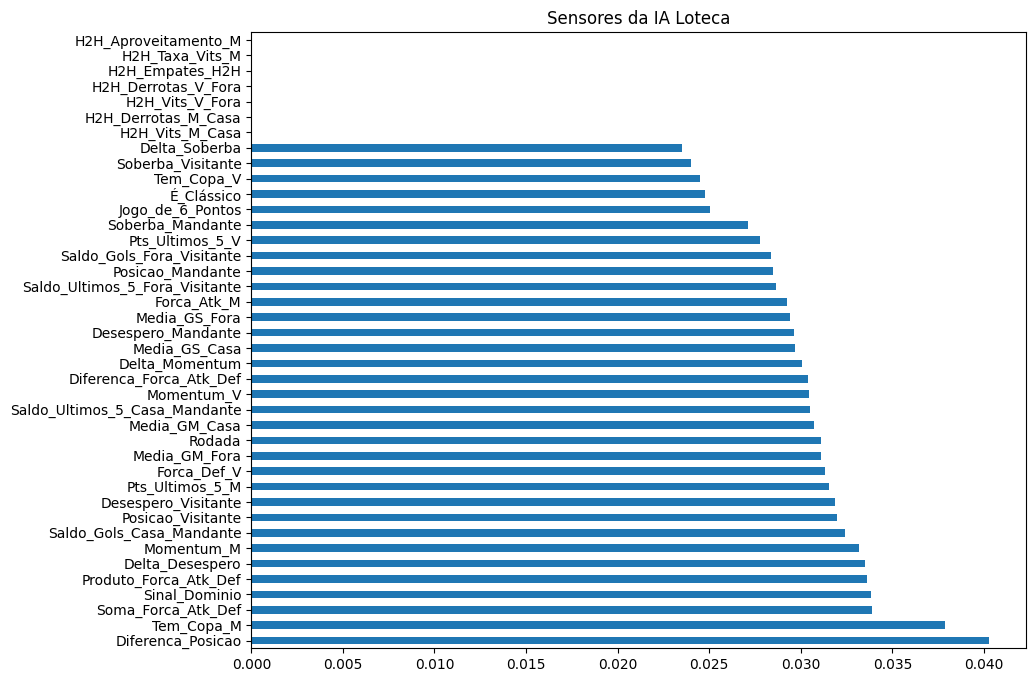

In [10]:
plt.figure(figsize=(10, 8))
importancias = pd.Series(chronos_ia.feature_importances_, index=X.columns)
importancias.nlargest(42).plot(kind='barh')
plt.title("Sensores da IA Loteca")
plt.show()

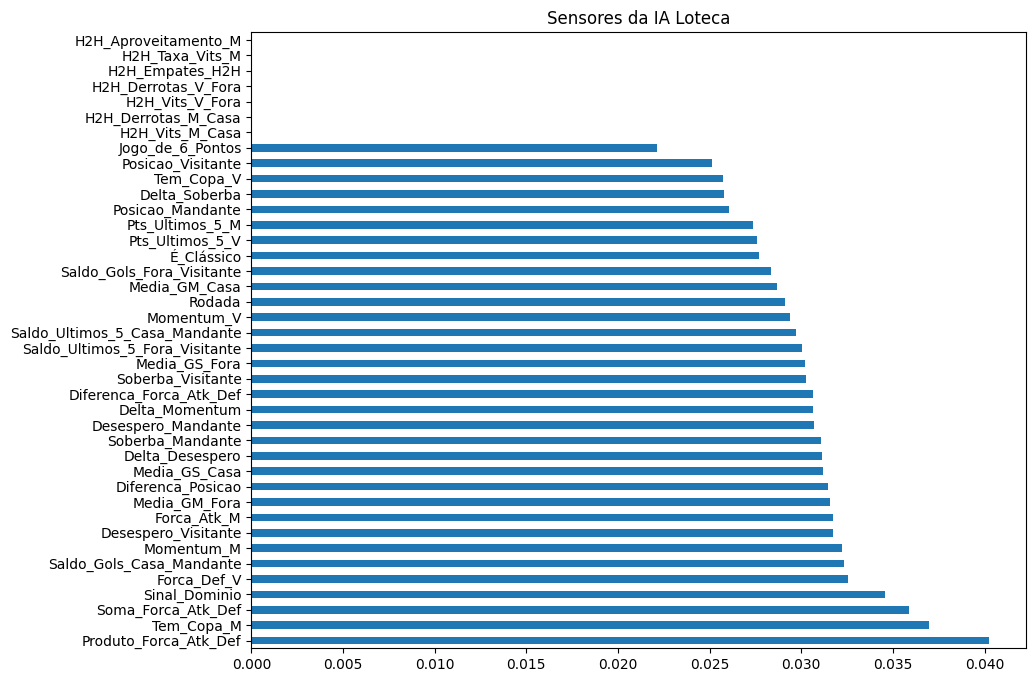

In [11]:
plt.figure(figsize=(10, 8))
importancias = pd.Series(modelo.feature_importances_, index=X.columns)
importancias.nlargest(42).plot(kind='barh')
plt.title("Sensores da IA Loteca")
plt.show()